In [14]:
import os
from glob import glob

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220909_VARprocess_EC_allsubjects_60.0s_segment_3600.0s_VARlength"

In [2]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.677187   0.611567       0.954759   
                             B           0.677187   0.611567       0.623973   
                             C           0.677187   0.611567       0.676957   
                             D           0.677187   0.611567       0.774807   
           2nd-segment       A           0.681361   0.621758       0.936727   
...                                           ...        ...            ...   
sub-010319 VAR-segments-mean D           0.748744   0.694447       0.812267   
sub-010321 VAR-segments-mean A           0.852567   0.793612       0.821455   
                             B           0.852567   0.793612       0.840159   
                             C           0.852567   0.793612       0.898207   
                             D           0.852567   0.793612       0.927711   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.257649   17.832145  14.448598   
                             B           0.244917   18.182121  13.470211   
                             C           0.224785   15.998933  14.052138   
                             D           0.272648   20.198653  13.478548   
           2nd-segment       A           0.263116   18.832078  13.971681   
...                                           ...         ...        ...   
sub-010319 VAR-segments-mean D           0.243495   12.958872  18.787744   
sub-010321 VAR-segments-mean A           0.245789   14.351003  17.146541   
                             B           0.242021   14.398224  16.813918   
                             C           0.253120   14.227122  17.802332   
                             D           0.259070   14.169350  18.268179   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.723157       0.089004   
                             B                0.085465       0.703048   
                             C                0.097272       0.085113   
                             D                0.104671       0.112497   
           2nd-segment       A                0.713707       0.107930   
...                                                ...            ...   
sub-010319 VAR-segments-mean D                0.069493       0.071834   
sub-010321 VAR-segments-mean A                0.761758       0.084299   
                             B                0.078237       0.756718   
                             C                0.070654       0.083325   
                             D                0.082910       0.065098   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.074515       0.113325  
                             B                0.094447       0.117039  
                             C                0.715302       0.102313  
                             D                0.079237       0.703595  
           2nd-segment       A                0.096022       0.082341  
...                                                ...            ...  
sub-010319 VAR-segments-mean D                0.072046       0.786627  
sub-010321 VAR-segments-mean A                0.080774       0.073169  
                             B                0.079815       0.085230  
                             C                0.770611       0.075410  
                             D                0.072377       0.779616  

[3232 rows x 10 columns]

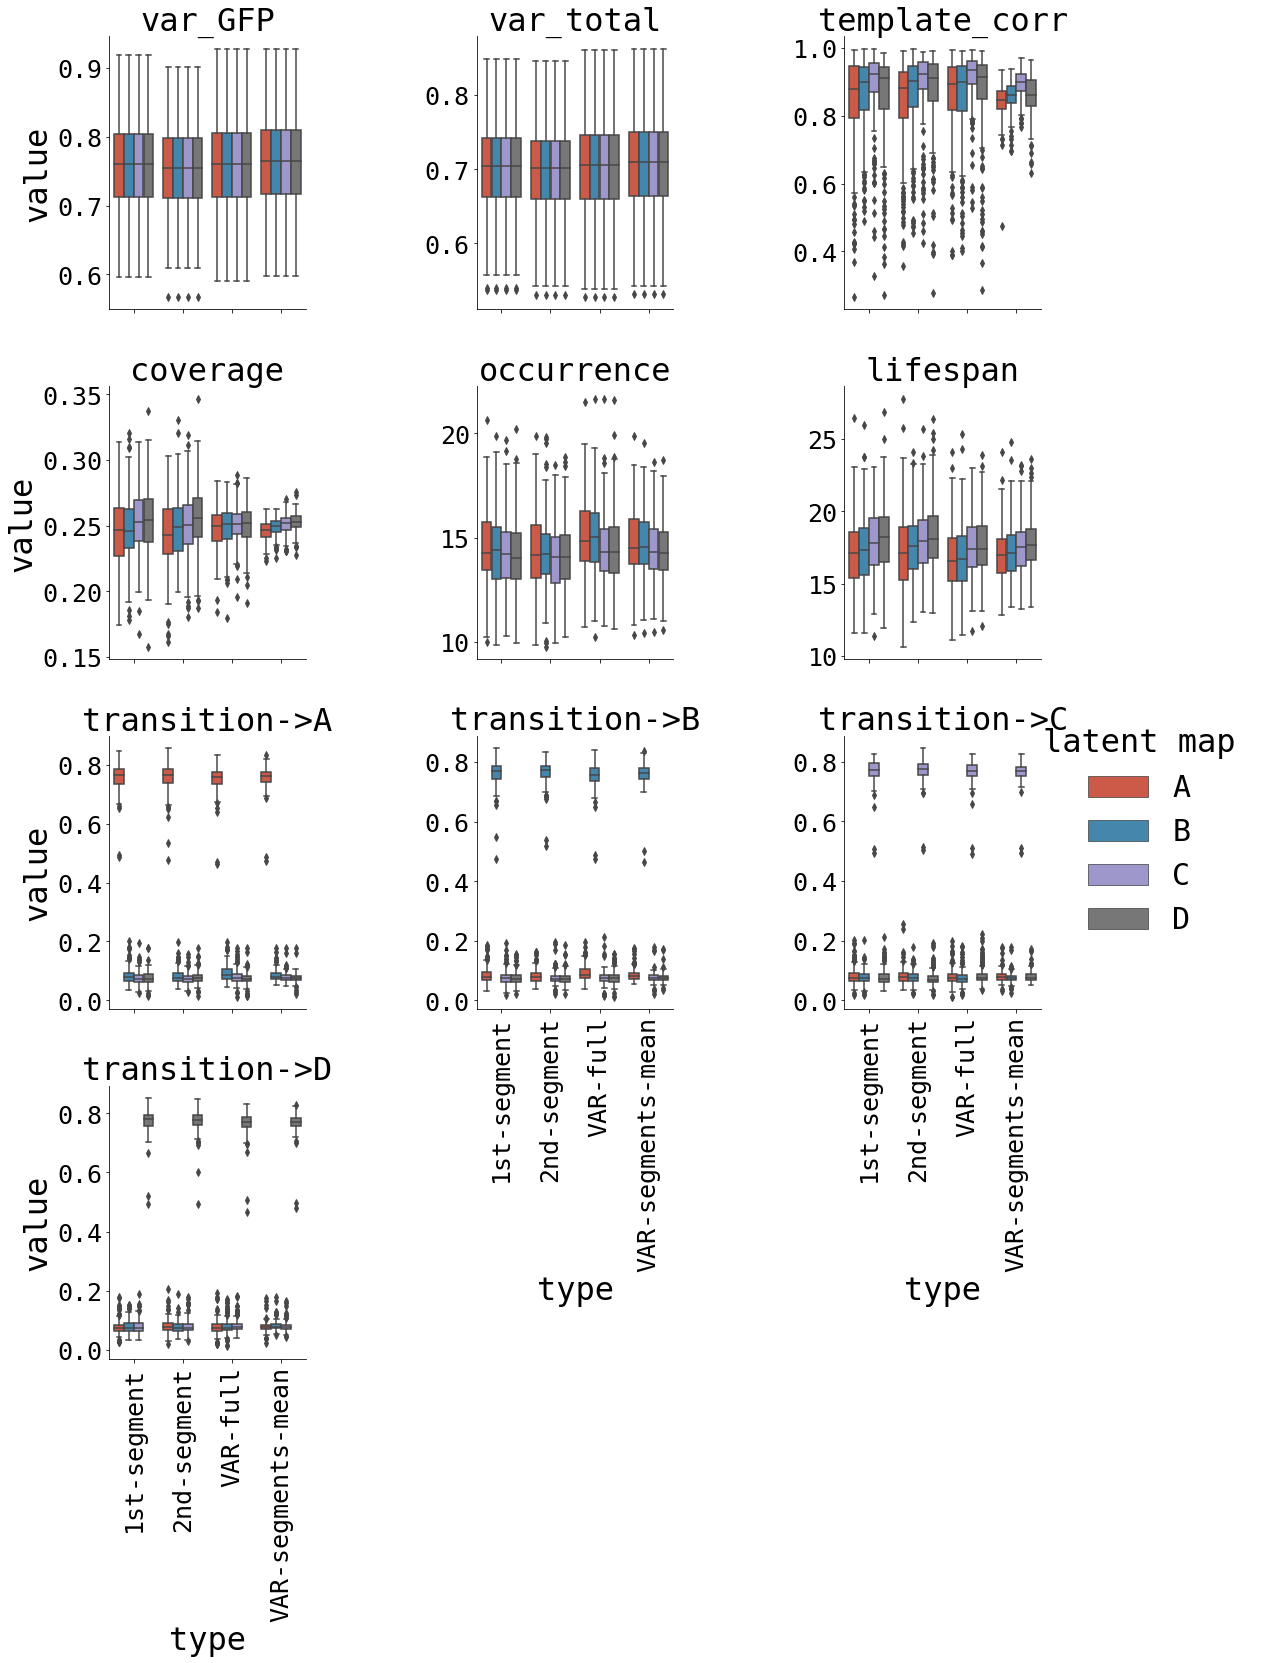

In [3]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
        "transition->A",
        "transition->B",
        "transition->C",
        "transition->D",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [4]:
static_stats_final["template_corr"].groupby(["type", "latent map"]).agg(
    ["mean", "median"]
)

mean    median
type              latent map                    
1st-segment       A           0.836011  0.878157
                  B           0.863256  0.898584
                  C           0.892816  0.923073
                  D           0.861181  0.911997
2nd-segment       A           0.838562  0.882829
                  B           0.861735  0.901555
                  C           0.891522  0.923630
                  D           0.872193  0.911048
VAR-full          A           0.863049  0.892729
                  B           0.858020  0.899221
                  C           0.914150  0.936215
                  D           0.868108  0.913429
VAR-segments-mean A           0.841984  0.847692
                  B           0.857758  0.861155
                  C           0.893438  0.898552
                  D           0.861178  0.862698

In [5]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

df1 = static_stats_final.reset_index()
var_mean_segments = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
static_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [6]:
SIMPLE_MEAN = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
]

TRANS = ["transition->A", "transition->B", "transition->C", "transition->D"]

simple_means = static_diffs.groupby(["subject_id", "diffs"])[SIMPLE_MEAN].mean()
trans_means = (
    static_diffs.groupby(["subject_id", "diffs"])[TRANS]
    .mean()
    .reset_index()
    .melt(id_vars=["subject_id", "diffs"])
    .groupby(["subject_id", "diffs"])["value"]
    .mean()
)
trans_means.name = "transition_matrix"
static_diffs = pd.concat([simple_means, trans_means], axis=1).reset_index()

In [7]:
DVS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition_matrix",
]
static_ts = []

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    ttests = pg.pairwise_ttests(
        data=static_diffs,
        dv=dv,
        within="diffs",
        subject="subject_id",
        padjust="fdr_by",
    )
    display(ttests)
    ttests["var"] = dv
    static_ts.append(ttests)

static_ts = pd.concat(static_ts)
static_ts.to_csv(os.path.join(RESULTS_FOLDER, "static_ttest.csv"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,12.212012,0.000007,0.000954,0.65047


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,-1.158249,200.0,two-sided,0.248144,0.454930,fdr_by,0.152,-0.009280
1,diffs,VAR-full,real_data,True,True,3.568673,200.0,two-sided,0.000449,0.001235,fdr_by,34.767,0.059501
2,diffs,VAR-segments-mean,real_data,True,True,3.722336,200.0,two-sided,0.000257,0.001235,fdr_by,58.383,0.071273


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,15.210038,4.300254e-07,0.000917,0.58098


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,-1.619053,200.0,two-sided,0.107012,0.196188,fdr_by,0.285,-0.008257
1,diffs,VAR-full,real_data,True,True,3.794353,200.0,two-sided,0.000196,0.000539,fdr_by,74.927,0.059698
2,diffs,VAR-segments-mean,real_data,True,True,4.154385,200.0,two-sided,0.000048,0.000266,fdr_by,277.347,0.069476


== template_corr ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,35.105078,8.986636e-15,0.057345,0.828735


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,7.565465,200.0,two-sided,1.379681e-12,3.794124e-12,fdr_by,4.908e+09,0.534294
1,diffs,VAR-full,real_data,True,True,-1.391836,200.0,two-sided,1.655180e-01,3.034497e-01,fdr_by,0.204,-0.105011
2,diffs,VAR-segments-mean,real_data,True,True,-8.520711,200.0,two-sided,3.823406e-15,2.102873e-14,fdr_by,1.526e+12,-0.575239


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,35.591247,5.945236e-15,0.054488,0.640493


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,5.248760,200.0,two-sided,3.893695e-07,1.070766e-06,fdr_by,2.676e+04,0.246299
1,diffs,VAR-full,real_data,True,True,-4.471652,200.0,two-sided,1.299743e-05,2.382862e-05,fdr_by,954.339,-0.337723
2,diffs,VAR-segments-mean,real_data,True,True,-7.574202,200.0,two-sided,1.309416e-12,7.201790e-12,fdr_by,5.164e+09,-0.546329


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,400,19.723478,6.771829e-09,0.000001,0.030793,0.652736,False,0.467987,1.542734e-33


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,6.126505,200.0,two-sided,4.689766e-09,2.579371e-08,fdr_by,1.862e+06,0.364113
1,diffs,VAR-full,real_data,True,True,3.772732,200.0,two-sided,2.126684e-04,5.848380e-04,fdr_by,69.49,0.300258
2,diffs,VAR-segments-mean,real_data,True,True,-1.544611,200.0,two-sided,1.240213e-01,2.273723e-01,fdr_by,0.254,-0.097867


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,400,9.831437,0.000068,0.000584,0.014959,0.679807,False,0.528994,3.043088e-28


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,5.820663,200.0,two-sided,2.302462e-08,1.266354e-07,fdr_by,4.025e+05,0.276419
1,diffs,VAR-full,real_data,True,True,-0.392331,200.0,two-sided,6.952316e-01,1.000000e+00,fdr_by,0.085,-0.029763
2,diffs,VAR-segments-mean,real_data,True,True,-3.938924,200.0,two-sided,1.130229e-04,3.108129e-04,fdr_by,125.191,-0.276984


== transition_matrix ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,20.713012,2.756842e-09,0.027316,0.817362


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,7.261528,200.0,two-sided,8.331640e-12,4.582402e-11,fdr_by,8.549e+08,0.419382
1,diffs,VAR-full,real_data,True,True,1.491439,200.0,two-sided,1.374218e-01,2.519399e-01,fdr_by,0.235,0.101910
2,diffs,VAR-segments-mean,real_data,True,True,-5.012264,200.0,two-sided,1.181435e-06,3.248946e-06,fdr_by,9281.6,-0.309365


In [8]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           2.702438  1.996421          2.0   
           2nd-segment           2.717315  1.997373          2.0   
           VAR-full              2.699795  1.998805          2.0   
sub-010003 1st-segment           4.155317  1.974333          2.0   
           2nd-segment           3.767818  1.992392          2.0   
...                                   ...       ...          ...   
sub-010316 VAR-segments-mean     3.898333  1.991519          2.0   
sub-010317 VAR-segments-mean     3.620252  1.995322          2.0   
sub-010318 VAR-segments-mean     2.998890  1.993351          2.0   
sub-010319 VAR-segments-mean     3.644411  1.992596          2.0   
sub-010321 VAR-segments-mean     3.561054  1.987352          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.267491         1.320866     80.000000  
           2nd-segment            1.257044         1.312458     36.000000  
           VAR-full               1.293150         1.336541     76.000000  
sub-010003 1st-segment            0.980855         1.014271     52.000000  
           2nd-segment            0.998433         1.031797     52.000000  
...                                    ...              ...           ...  
sub-010316 VAR-segments-mean      1.029764         1.069258     52.000000  
sub-010317 VAR-segments-mean      1.080679         1.127578     52.666667  
sub-010318 VAR-segments-mean      1.193044         1.255923     44.000000  
sub-010319 VAR-segments-mean      1.050555         1.091339     52.000000  
sub-010321 VAR-segments-mean      1.088474         1.130625     52.000000  

[808 rows x 6 columns]

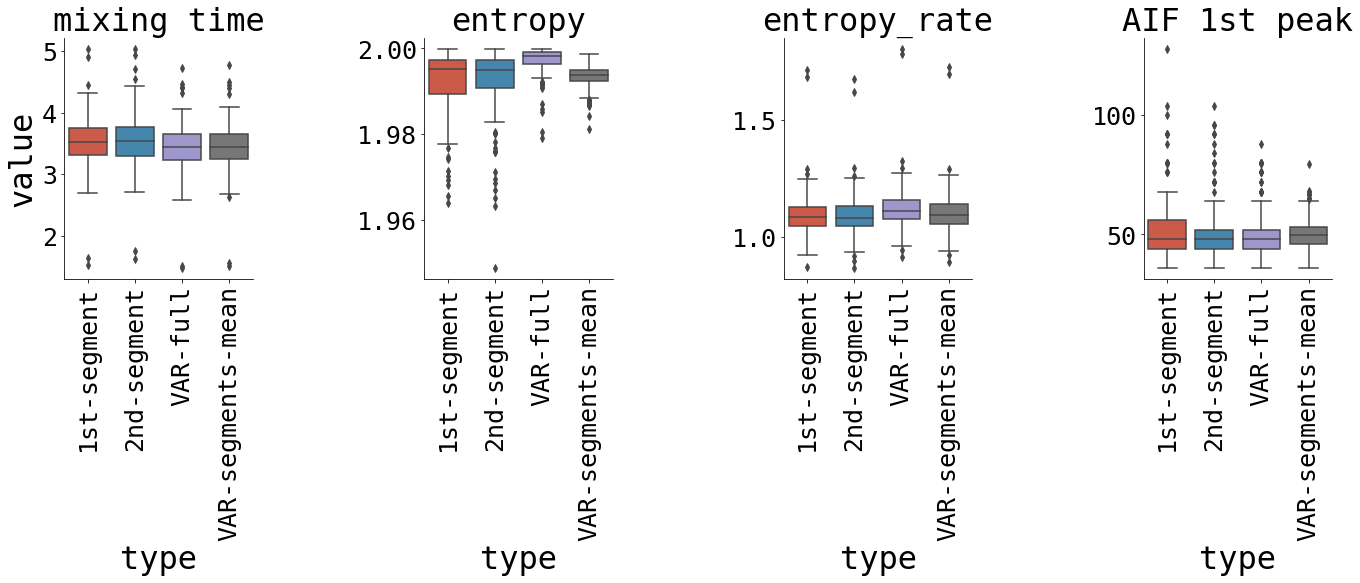

In [9]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [10]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010002,2.702438,1.996421,2.0,1.267491,1.320866,80.0,1st-segment
0,sub-010002,2.717315,1.997373,2.0,1.257044,1.312458,36.0,2nd-segment
0,sub-010002,2.797356,1.998948,2.0,1.268535,1.326038,36.0,VAR-1-segment
0,sub-010002,2.745991,1.994802,2.0,1.256539,1.309744,36.0,VAR-10-segment
0,sub-010002,2.687946,1.986167,2.0,1.243856,1.303790,36.0,VAR-11-segment
...,...,...,...,...,...,...,...,...
0,sub-010321,3.726021,1.988071,2.0,1.088170,1.131093,52.0,VAR-60-segment
0,sub-010321,3.469599,1.998700,2.0,1.091133,1.133114,52.0,VAR-7-segment
0,sub-010321,3.759039,1.978621,2.0,1.079427,1.121769,52.0,VAR-8-segment
0,sub-010321,3.715538,1.991651,2.0,1.087088,1.125159,52.0,VAR-9-segment


In [11]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = all_segments_diffs.reset_index().groupby(["subject_id"]).mean()

df1 = dynamic_stats_final.reset_index()
var_mean_segments = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
dynamic_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [12]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010002,0.000221,9.067611e-07,0.000109,1936.000000,real_data
1,sub-010003,0.150155,3.261120e-04,0.000309,0.000000,real_data
2,sub-010004,0.303523,2.311796e-05,0.013825,0.000000,real_data
3,sub-010005,0.047272,5.541374e-05,0.000213,144.000000,real_data
4,sub-010006,0.041617,7.636598e-06,0.001069,16.000000,real_data
...,...,...,...,...,...,...
604,sub-010316,0.006396,1.239496e-04,0.000174,0.000000,VAR-segments-mean
605,sub-010317,0.058628,5.609036e-05,0.002839,0.444444,VAR-segments-mean
606,sub-010318,0.013724,3.998191e-05,0.001088,0.000000,VAR-segments-mean
607,sub-010319,0.000958,4.140449e-05,0.000506,0.000000,VAR-segments-mean


In [13]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

dynamic_ts = []
for dv in DVS:
    print(f"== {dv} ==")
    display(
        pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id")
    )
    ttests = pg.pairwise_ttests(
        data=dynamic_diffs,
        dv=dv,
        within="diffs",
        subject="subject_id",
        padjust="fdr_by",
    )
    display(ttests)
    ttests["var"] = dv
    dynamic_ts.append(ttests)

dynamic_ts = pd.concat(dynamic_ts)
dynamic_ts.to_csv(os.path.join(RESULTS_FOLDER, "dynamic_ttest.csv"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,7.138436,0.000899,0.00746,0.572248


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,4.105112,200.0,two-sided,0.000059,0.000324,fdr_by,230.487,0.080767
1,diffs,VAR-full,real_data,True,True,2.968419,200.0,two-sided,0.003359,0.009237,fdr_by,5.538,0.220606
2,diffs,VAR-segments-mean,real_data,True,True,1.900222,200.0,two-sided,0.058842,0.107878,fdr_by,0.46,0.136048


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,6.998414,0.001029,0.00641,0.71173


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,4.660937,200.0,two-sided,0.000006,0.000032,fdr_by,2066.844,0.176227
1,diffs,VAR-full,real_data,True,True,0.665478,200.0,two-sided,0.506512,0.928605,fdr_by,0.098,0.041143
2,diffs,VAR-segments-mean,real_data,True,True,-3.085412,200.0,two-sided,0.002320,0.006381,fdr_by,7.735,-0.170649


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,400,37.279378,1.425608e-15,0.045652,0.630988


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,7.243621,200.0,two-sided,9.251244e-12,5.088184e-11,fdr_by,7.722e+08,0.304258
1,diffs,VAR-full,real_data,True,True,6.349041,200.0,two-sided,1.426367e-09,3.922510e-09,fdr_by,5.87e+06,0.494317
2,diffs,VAR-segments-mean,real_data,True,True,3.396695,200.0,two-sided,8.227748e-04,1.508420e-03,fdr_by,19.915,0.229920


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,400,1.276049,0.280272,0.271564,0.00157,0.67827,False,0.525661,1.622577e-28


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments-mean,True,True,2.413141,200.0,two-sided,0.016718,0.091946,fdr_by,1.336,0.083349
1,diffs,VAR-full,real_data,True,True,-0.042957,200.0,two-sided,0.965779,1.000000,fdr_by,0.079,-0.002957
2,diffs,VAR-segments-mean,real_data,True,True,-1.249875,200.0,two-sided,0.212806,0.585216,fdr_by,0.17,-0.088203


In [27]:
dfs =  []
for file in glob("../../results/*allsubjects*/*ttest.csv"):
    df = pd.read_csv(file, index_col=0)
    segment = float(file.split("_")[4][:-1])
    var_length = float(file.split("_")[6][:-1])
    df["VAR length"] = var_length
    df["Segment length"] = segment
    dfs.append(df)

In [28]:
dfs = pd.concat(dfs)

In [30]:
dfs.to_csv("../../results/VAR_ttests.csv")